In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, DecisionTreeClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from prettytable import PrettyTable
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Estimator

# Initialize Spark session
spark = SparkSession.builder.appName("PredictiveMaintenance").getOrCreate()

# Load the dataset
data = spark.read.csv("predictive_maintenance.csv", header=True, inferSchema=True)

# Display schema and summary
data.printSchema()
data.describe().show()

# Drop unnecessary columns (already cleaned in your code)
data = data.drop("UDI", "Product ID", "Failure Type")

# Map 'Type' to numeric using StringIndexer
indexer = StringIndexer(inputCol="Type", outputCol="TypeIndex")
data = indexer.fit(data).transform(data)

# Vectorize features
numeric_cols = ['Air temperature [K]', 'Process temperature [K]',
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
assembler = VectorAssembler(inputCols=numeric_cols + ['TypeIndex'], outputCol="features")
data = assembler.transform(data)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Encode target variable
target_indexer = StringIndexer(inputCol="Target", outputCol="label")
data = target_indexer.fit(data).transform(data)

# Split the data into train and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train Gradient Boosting Classifier
gbt = GBTClassifier(featuresCol="scaledFeatures", labelCol="label", maxIter=100)
gbt_model = gbt.fit(train_data)

# Predict on test data
predictions = gbt_model.transform(test_data)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# F1 Score
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Display evaluation metrics in a table
metrics_table = PrettyTable()
metrics_table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]

# Add results for Gradient Boosting Classifier
metrics_table.add_row(["Gradient Boosting", f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"])

# Train and evaluate multiple models
models = {
    'Logistic Regression': LogisticRegression(featuresCol="scaledFeatures", labelCol="label"),
    'Random Forest': RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label"),
    'Gradient Boosting': GBTClassifier(featuresCol="scaledFeatures", labelCol="label"),
    'Decision Tree': DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label"),
    'Naive Bayes': NaiveBayes(featuresCol="scaledFeatures", labelCol="label"),
    'Support Vector Machine': LinearSVC(featuresCol="scaledFeatures", labelCol="label")
}

for model_name, model in models.items():
    # Train model
    trained_model = model.fit(train_data)

    # Predict on test data
    predictions = trained_model.transform(test_data)

    # Evaluate metrics
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    # Add results to the table
    metrics_table.add_row([model_name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}"])

# Print the table with evaluation metrics
print(metrics_table)

# Anomaly Detection using Isolation Forest (via Bisecting KMeans)
# BisectingKMeans is used here to detect anomalies in a dataset by clustering the data

kmeans = BisectingKMeans(k=2, featuresCol="scaledFeatures", predictionCol="prediction")
model_kmeans = kmeans.fit(data)
predictions_kmeans = model_kmeans.transform(data)

# Filter anomalies (data points not assigned to the main cluster)
anomalies = predictions_kmeans.filter(col("prediction") == 1)  # Adjust based on the cluster behavior
print(f"Anomalies detected: {anomalies.count()}")

# Save the best model
gbt_model.write().overwrite().save("best_model_gbt")
print("Best model saved.")


root
 |-- UDI: integer (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Air temperature [K]: double (nullable = true)
 |-- Process temperature [K]: double (nullable = true)
 |-- Rotational speed [rpm]: integer (nullable = true)
 |-- Torque [Nm]: double (nullable = true)
 |-- Tool wear [min]: integer (nullable = true)
 |-- Target: integer (nullable = true)
 |-- Failure Type: string (nullable = true)

+-------+------------------+----------+-----+-------------------+-----------------------+----------------------+------------------+-----------------+-----------------+--------------------+
|summary|               UDI|Product ID| Type|Air temperature [K]|Process temperature [K]|Rotational speed [rpm]|       Torque [Nm]|  Tool wear [min]|           Target|        Failure Type|
+-------+------------------+----------+-----+-------------------+-----------------------+----------------------+------------------+-----------------+-----------------+

In [ ]:
from pyspark.ml.classification import GBTClassificationModel
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import sys

# Initialize Spark session
spark = SparkSession.builder \
    .appName("PredictiveMaintenance") \
    .getOrCreate()

# Load the saved model
model_path = "best_model_gbt"  # Path to your saved model
loaded_model = GBTClassificationModel.load(model_path)

# Function to collect user input
def get_user_input():
    print("\nPlease provide the following sensor data for failure prediction:")
    try:
        air_temp = float(input("Air temperature [K]: "))
        process_temp = float(input("Process temperature [K]: "))
        rotational_speed = float(input("Rotational speed [rpm]: "))
        torque = float(input("Torque [Nm]: "))
        tool_wear = float(input("Tool wear [min]: "))
        machine_type = input("Type (L, M, H): ").strip().upper()

        # Map machine type to numeric
        type_mapping = {'L': 0.0, 'M': 1.0, 'H': 2.0}
        if machine_type not in type_mapping:
            print("Invalid machine type. Please enter 'L', 'M', or 'H'.")
            sys.exit(1)

        type_index = type_mapping[machine_type]

        # Return the features
        return [air_temp, process_temp, rotational_speed, torque, tool_wear, type_index]
    except ValueError:
        print("Invalid input. Please enter numeric values for all fields except Type.")
        sys.exit(1)

# Predict failure type based on user input
def predict_failure():
    # Get user input
    features = get_user_input()

    # Assemble features into a feature vector
    assembler = VectorAssembler(inputCols=['air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear', 'type'], outputCol='features')
    input_data = spark.createDataFrame([tuple(features)], ['air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear', 'type'])

    # Assemble the features into the feature column
    assembled_data = assembler.transform(input_data)

    # Apply StandardScaler (if your model was trained with scaled features)
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
    scaler_model = scaler.fit(assembled_data)
    scaled_data = scaler_model.transform(assembled_data)

    # Predict using the loaded model
    prediction = loaded_model.transform(scaled_data)

    # Retrieve the predicted label
    predicted_label = prediction.collect()[0].prediction

    # Map prediction to failure status
    label_mapping = {0.0: "No Failure", 1.0: "Failure"}
    result = label_mapping.get(predicted_label, "Unknown")

    print(f"\nPrediction Result: {result}")

# Call the prediction function
predict_failure()



Please provide the following sensor data for failure prediction:
Air temperature [K]: 300
Process temperature [K]: 310
Rotational speed [rpm]: 1500
Torque [Nm]: 50
Tool wear [min]: 200
Type (L, M, H): M

Prediction Result: No Failure


In [ ]:
pip install flask


In [ ]:
import pickle

# Save the model
with open('gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
# First install required packages
!pip install flask-ngrok pyngrok flask scikit-learn

In [ ]:
from flask import Flask, request, jsonify
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import os
from datetime import datetime
import logging

# Initialize Flask app
app = Flask(__name__)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Load the trained model and scaler
try:
    model = joblib.load('gradient_boosting_model.joblib')
    scaler = joblib.load('scaler.joblib')
    logger.info("Model and scaler loaded successfully")
except Exception as e:
    logger.error(f"Error loading model or scaler: {str(e)}")

# Input validation functions
def validate_numeric_input(value, field_name, min_value=None, max_value=None):
    try:
        value = float(value)
        if min_value is not None and value < min_value:
            return False, f"{field_name} must be greater than {min_value}"
        if max_value is not None and value > max_value:
            return False, f"{field_name} must be less than {max_value}"
        return True, value
    except ValueError:
        return False, f"{field_name} must be a numeric value"

def validate_machine_type(type_value):
    valid_types = {'L': 0, 'M': 1, 'H': 2}
    if type_value not in valid_types:
        return False, "Machine type must be 'L', 'M', or 'H'"
    return True, valid_types[type_value]

# Route for predictions
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data
        data = request.get_json()
        if not data:
            return jsonify({"error": "No input data provided"}), 400

        # Validate input data
        required_fields = {
            'air_temp': (200, 400),  # K
            'process_temp': (200, 400),  # K
            'rotational_speed': (0, 3000),  # rpm
            'torque': (0, 100),  # Nm
            'tool_wear': (0, 300),  # min
            'type': None
        }

        input_values = []
        for field, limits in required_fields.items():
            if field not in data:
                return jsonify({"error": f"Missing required field: {field}"}), 400

            if field == 'type':
                valid, value = validate_machine_type(data[field].upper())
            else:
                valid, value = validate_numeric_input(data[field], field, limits[0], limits[1])

            if not valid:
                return jsonify({"error": value}), 400
            input_values.append(value)

        # Scale the features
        features = scaler.transform(np.array(input_values).reshape(1, -1))

        # Make prediction
        prediction = model.predict(features)[0]
        prediction_proba = model.predict_proba(features)[0]

        # Create response
        result = {
            "prediction": "Failure" if prediction == 1 else "No Failure",
            "probability": {
                "no_failure": float(prediction_proba[0]),
                "failure": float(prediction_proba[1])
            },
            "timestamp": datetime.now().isoformat()
        }

        # Log the prediction
        logger.info(f"Prediction made: {result}")

        return jsonify(result), 200

    except Exception as e:
        logger.error(f"Error making prediction: {str(e)}")
        return jsonify({"error": "Internal server error"}), 500

# Route for model information
@app.route('/model-info', methods=['GET'])
def model_info():
    try:
        return jsonify({
            "model_type": "Gradient Boosting Classifier",
            "features": [
                "Air temperature [K]",
                "Process temperature [K]",
                "Rotational speed [rpm]",
                "Torque [Nm]",
                "Tool wear [min]",
                "Machine Type"
            ],
            "machine_types": ["L", "M", "H"],
            "version": "1.0"
        }), 200
    except Exception as e:
        logger.error(f"Error retrieving model info: {str(e)}")
        return jsonify({"error": "Internal server error"}), 500

# Health check endpoint
@app.route('/health', methods=['GET'])
def health():
    try:
        return jsonify({
            "status": "healthy",
            "timestamp": datetime.now().isoformat()
        }), 200
    except Exception as e:
        logger.error(f"Error in health check: {str(e)}")
        return jsonify({"status": "unhealthy"}), 500

if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5000))
    app.run(host='0.0.0.0', port=port, debug=False)

ERROR:__main__:Error loading model or scaler: 


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


In [ ]:
df = pd.read_csv('predictive_maintenance.csv')

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
df.shape

(10000, 10)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Target,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [ ]:
df.dtypes

,0
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Target,int64
Failure Type,object


In [ ]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [ ]:
df.isnull().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.drop('UDI',axis=1,inplace=True)

In [ ]:
df.drop('Product ID',axis=1,inplace=True)
df.drop('Failure Type',axis=1,inplace=True)

In [ ]:
df.Target.value_counts()

,count
Target,
0,9661
1,339


In [ ]:
numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_cols = ['Type']


In [ ]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0


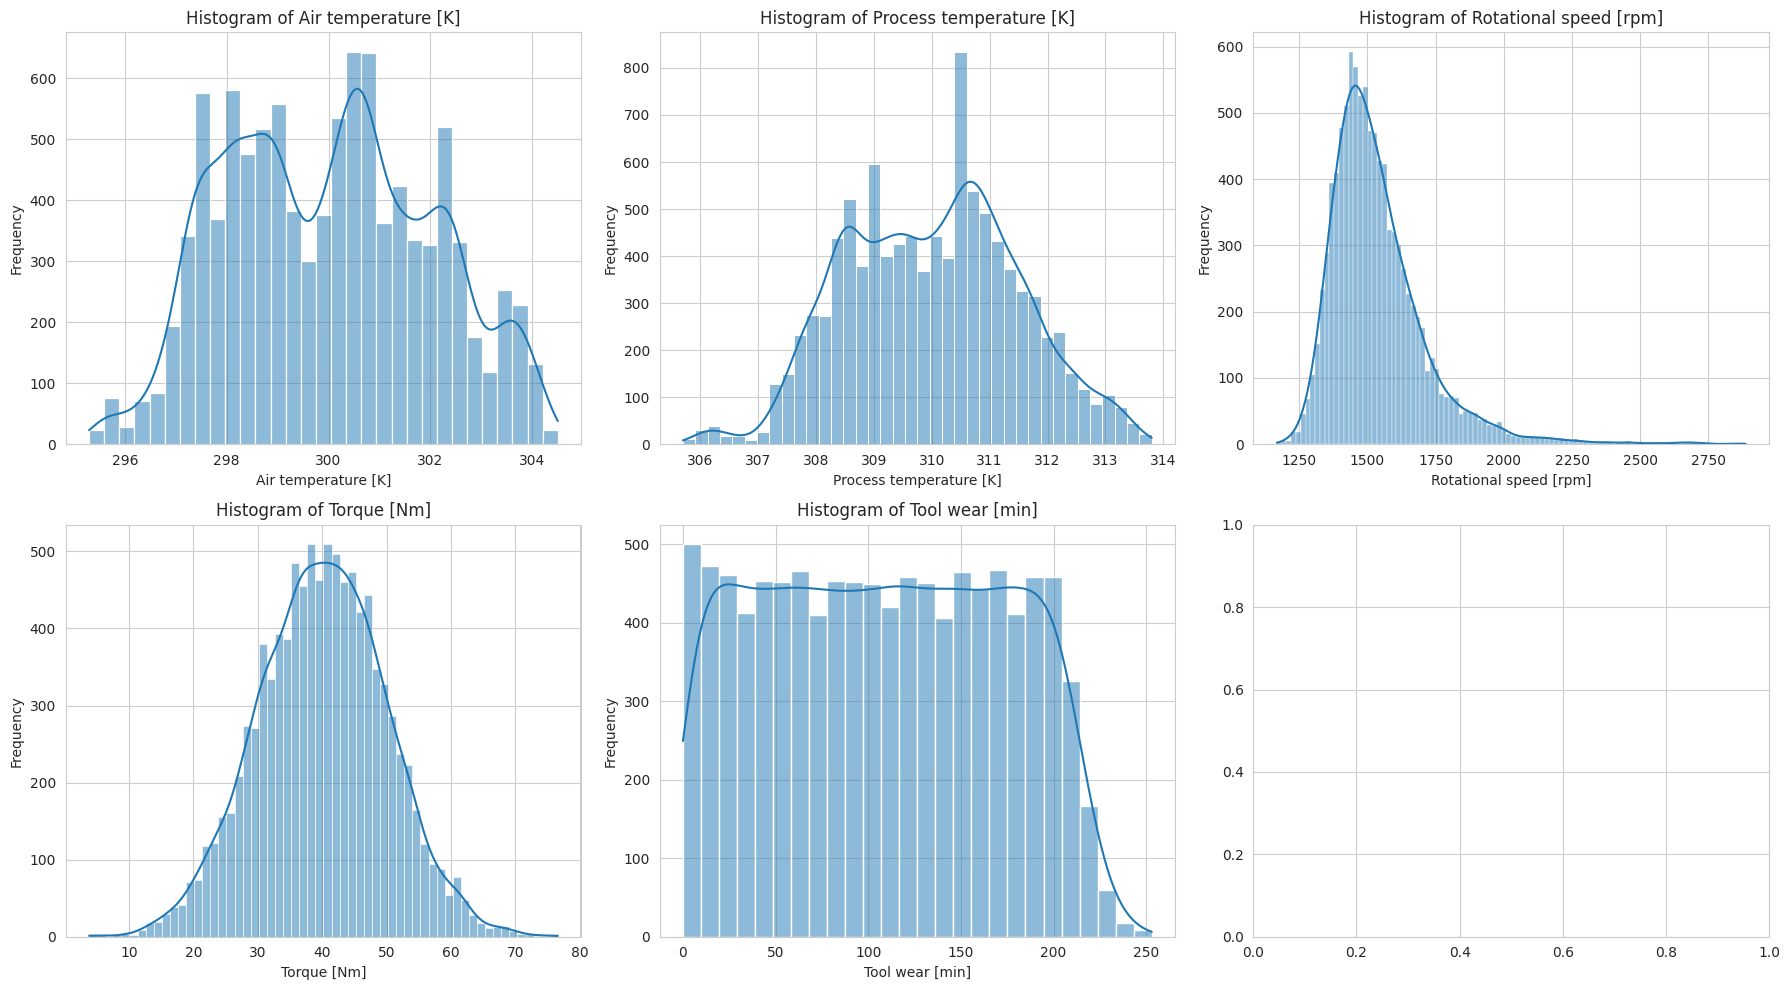

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style(style="whitegrid")

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through numeric columns and create histograms
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


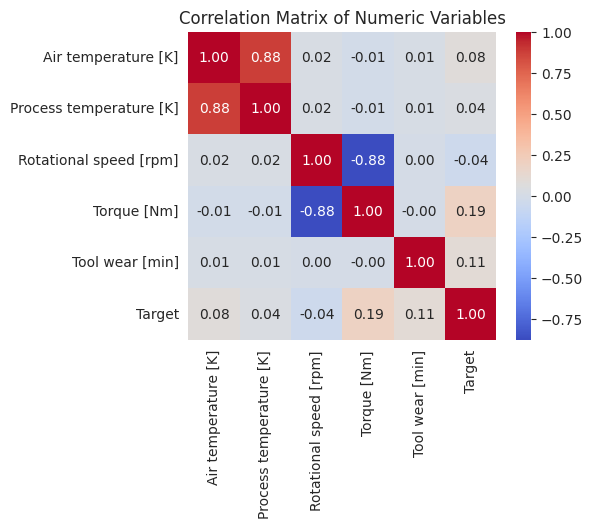

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target']

# Calculate the correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()


<Figure size 400x400 with 0 Axes>

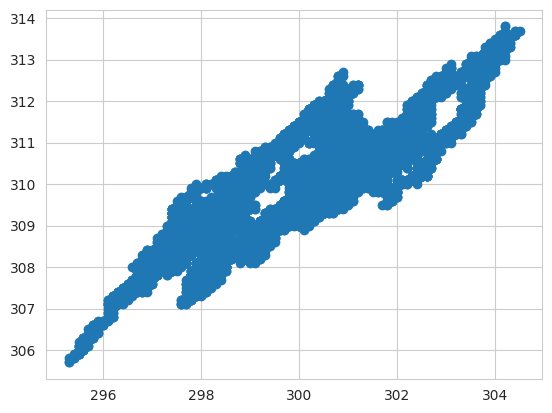

<Figure size 400x400 with 0 Axes>

In [ ]:
plt.scatter(df['Air temperature [K]'], df['Process temperature [K]'])
plt.figure(figsize=(4, 4))

<Figure size 400x400 with 0 Axes>

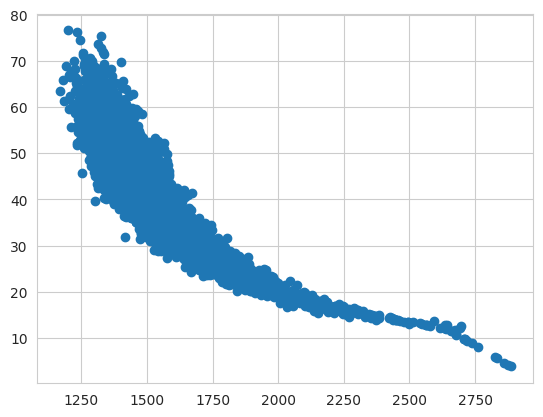

<Figure size 400x400 with 0 Axes>

In [ ]:
plt.scatter(df['Rotational speed [rpm]'], df['Torque [Nm]'])
plt.figure(figsize=(4, 4))

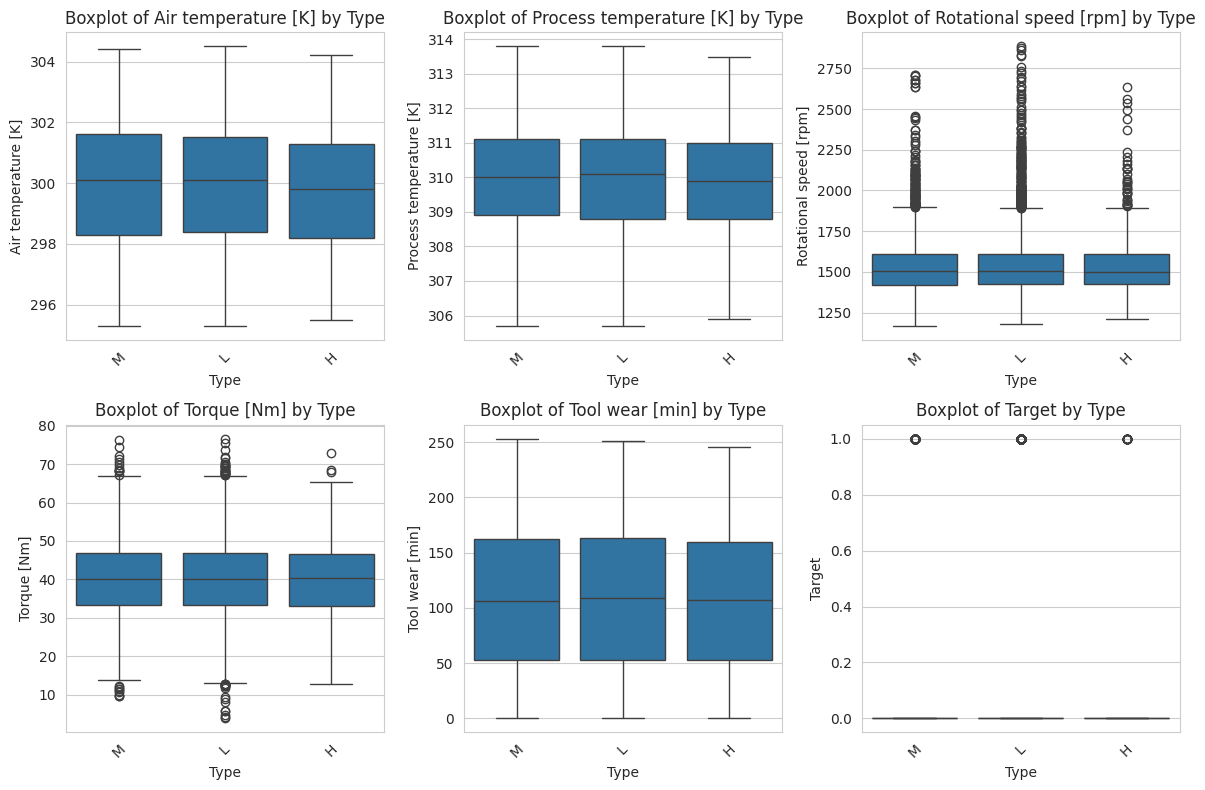

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Type', y=col, data=df)
    plt.title(f'Boxplot of {col} by Type')
    plt.xlabel('Type')
    plt.ylabel(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


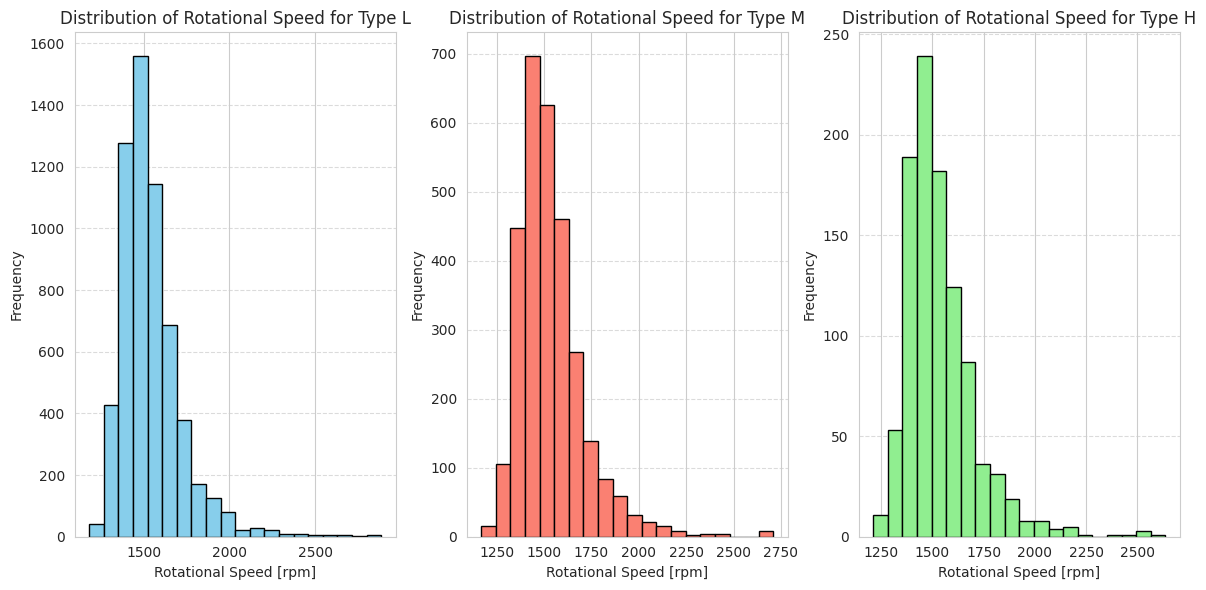

In [ ]:
import matplotlib.pyplot as plt

# Filter data for each type: L, M, H
type_L_data = df[df['Type'] == 'L']
type_M_data = df[df['Type'] == 'M']
type_H_data = df[df['Type'] == 'H']

# Plot the distribution of 'Rotational speed [rpm]' for each type
plt.figure(figsize=(12, 6))

# Plot for Type L
plt.subplot(1, 3, 1)
plt.hist(type_L_data['Rotational speed [rpm]'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Rotational Speed for Type L')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Type M
plt.subplot(1, 3, 2)
plt.hist(type_M_data['Rotational speed [rpm]'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Rotational Speed for Type M')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Type H
plt.subplot(1, 3, 3)
plt.hist(type_H_data['Rotational speed [rpm]'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Rotational Speed for Type H')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
# Replace 'df' with the name of your DataFrame if it's different

# Save DataFrame to CSV file
df.to_csv('predictive_maintenance-cleaned.csv', index=False)

print("DataFrame saved successfully.")


DataFrame saved successfully.


In [ ]:
data = pd.read_csv('predictive_maintenance-cleaned.csv')

In [ ]:
data['Type'] = data.Type.map({'L':0, 'M':1, 'H':2})

In [ ]:
data.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1,298.1,308.6,1551,42.8,0,0
1,0,298.2,308.7,1408,46.3,3,0
2,0,298.1,308.5,1498,49.4,5,0
3,0,298.2,308.6,1433,39.5,7,0
4,0,298.2,308.7,1408,40.0,9,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  int64  
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 547.0 KB


In [ ]:
data = data.astype(float)


In [ ]:
x = data.drop('Target', axis=1)
y = data.Target

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [ ]:
x


array([[ 0.74441274, -0.95238944, -0.94735989,  0.06818514,  0.28219976,
        -1.69598374],
       [-0.74530658, -0.90239341, -0.879959  , -0.72947151,  0.63330802,
        -1.6488517 ],
       [-0.74530658, -0.95238944, -1.01476077, -0.22744984,  0.94428963,
        -1.61743034],
       ...,
       [ 0.74441274, -0.50242514, -0.94735989,  0.59251888, -0.66077672,
        -1.35034876],
       [ 2.23413206, -0.50242514, -0.879959  , -0.72947151,  0.85400464,
        -1.30321671],
       [ 0.74441274, -0.50242514, -0.879959  , -0.2162938 ,  0.02137647,
        -1.22466331]])

In [ ]:
y

,Target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
9995,0.0
9996,0.0
9997,0.0
9998,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib

# Train Gradient Boosting Model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)
print(classification_report(y_test, y_pred))



Model accuracy: 0.9825
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1939
         1.0       0.80      0.57      0.67        61

    accuracy                           0.98      2000
   macro avg       0.89      0.78      0.83      2000
weighted avg       0.98      0.98      0.98      2000



In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Define the models
model_list = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Classifier (SVC)': SVC(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Initialize dictionary to hold model accuracies
model_score = {}

# Train each model and evaluate accuracy, precision, recall, and F1-score
for name, model in model_list.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test data
    score = accuracy_score(y_test, y_pred)  # Calculate accuracy
    model_score[name] = score  # Store accuracy in dictionary

    # Print accuracy, precision, recall, and F1-score
    print(f"\n{name} Model Performance:")
    print(f"Accuracy: {score:.4f}")
    print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))

# Find the model with the best accuracy score
best_model_score = max(model_score.values())
best_model_name = max(model_score, key=model_score.get)  # Get the name of the best model
best_model = model_list[best_model_name]

print(f"\nBest Model: {best_model_name} with Accuracy: {best_model_score:.4f}")



Logistic Regression Model Performance:
Accuracy: 0.9730
              precision    recall  f1-score   support

  No Failure       0.98      1.00      0.99      1939
     Failure       0.64      0.26      0.37        61

    accuracy                           0.97      2000
   macro avg       0.81      0.63      0.68      2000
weighted avg       0.97      0.97      0.97      2000


K-Nearest Neighbors (KNN) Model Performance:
Accuracy: 0.9790
              precision    recall  f1-score   support

  No Failure       0.98      1.00      0.99      1939
     Failure       0.85      0.38      0.52        61

    accuracy                           0.98      2000
   macro avg       0.92      0.69      0.76      2000
weighted avg       0.98      0.98      0.98      2000


Decision Tree Model Performance:
Accuracy: 0.9785
              precision    recall  f1-score   support

  No Failure       0.99      0.99      0.99      1939
     Failure       0.62      0.75      0.68        61

    accurac